# Wisonsin Breast Cacner
https://riverml.xyz/0.14.0/examples/batch-to-online/

In [3]:
from online_hui_walter.latent_structure_analysis import latent_profiles
from online_hui_walter.rolling_metrics import get_marginals, alpha1, alpha2, beta1, beta2
from river import stream
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from sklearn import datasets
from sklearn.linear_model import LogisticRegression


from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from river import compose
from river import compat

import numpy as np
from sklearn.mixture import GaussianMixture

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = datasets.load_breast_cancer()

feat1 = [
    #'mean radius',
    'mean texture',
]
feat2 = [
    'mean concavity',
    #'mean symmetry'
]

df = pd.read_csv("latent_class_breast_cancer.csv")

#df_sample = df.sample(200, random_state=1)
y = data['target']  
X = data['data']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)
selected_features = [list(data['feature_names']).index(x) for x in feat1]
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
clf1 = svm.SVC(random_state=0).fit(X_train_sel, y_train)
y_pred = clf1.predict(X_test_sel)
print(classification_report(
    y_test,
    y_pred,
    target_names=["Benign", "Malicious"]))

cm = confusion_matrix(y_test, y_pred)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print(FPR, FNR)
fpr1 = FPR
fnr1 = FNR

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=0)
selected_features = [list(data['feature_names']).index(x) for x in feat2]
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
clf2 =  RandomForestClassifier(max_depth=2, random_state=0).fit(X_train_sel, y_train)
y_pred = clf2.predict(X_test_sel)
print(classification_report(
    y_test,
    y_pred,
    target_names=["Benign", "Malicious"]
))

cm = confusion_matrix(y_test, y_pred)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print(FPR, FNR)
fpr2 = FPR
fnr2 = FNR

              precision    recall  f1-score   support

      Benign       0.64      0.66      0.65        98
   Malicious       0.82      0.80      0.81       187

    accuracy                           0.75       285
   macro avg       0.73      0.73      0.73       285
weighted avg       0.76      0.75      0.76       285

0.336734693877551 0.19786096256684493
              precision    recall  f1-score   support

      Benign       0.81      0.80      0.81       101
   Malicious       0.89      0.90      0.89       184

    accuracy                           0.86       285
   macro avg       0.85      0.85      0.85       285
weighted avg       0.86      0.86      0.86       285

0.19801980198019803 0.10326086956521739


In [156]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(FPR, FNR)

0.18604651162790697 0.056338028169014086 8


In [ ]:

# Latent Profile Analysis
gmm = GaussianMixture(n_components=2, random_state=0)
history = []
profiles = []
predictions = []
for j in range(200):
    for i, sample in enumerate(stream.iter_sklearn_dataset(datasets.load_breast_cancer(), shuffle=True, seed=42)):
        xi, yi = sample
        sample1 = [xi[x] for x in feat1]
        sample2 = [xi[x] for x in feat2]
        history.append([xi[x] for x in feat1 + feat2])
        if i >= 5:
            profiles.append(gmm.fit_predict(np.asarray(history)))
        predictions.append([clf1.predict([sample1]), clf2.predict([sample2]), yi])


In [176]:
def table(profiles, predictions):

    t = np.zeros((2,2,2))
    for i, prediction in enumerate(predictions):
        pop = profiles[i]
        t1, t2, t_true = prediction
        # print(pop, t1, t2, t_true)
        # input()
        t1 = t1[0]
        t2 = t2[0]
        if t1 == 1 and t2 == 1:
            t[0,0,pop] += 1
        if t1 == 1 and t2 == 0:
            t[0,1,pop] += 1
        if t1 == 0 and t2 == 1:
            t[1,0,pop] += 1
        if t1 == 0 and t2 == 0:
            t[1,1,pop] += 1
    return t

def get_marginals(table):
    output = []
    if table.shape != (2, 2, 2):
        raise Exception("More than two pops or tests, not implemented.")
    for i in range(2):
        colsums = table[:,:,i].sum(axis=1)
        rowsums = table[:,:,i].sum(axis=0)
        n = np.concatenate(t[:,:,i]).sum()
        flattened = t[:,:,i].ravel()
        # a, b, c, d, e, f, g, h, n
        output.append(list(flattened) + list(colsums) + list(rowsums) + [n])
    return output

def beta1(d1, d2, e1, e2, g1, g2, n1, n2, F):
    numerator = (g1*e2-e1*g2)/(n1*n2) - d1/n1  + d2/n2 - F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator

def beta2(d1, d2, e1, e2, g1, g2, n1, n2, F):
    numerator = (g2*e1 - e2* g1)/(n1*n2) - d1/n1 + d2/n2 - F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator


def alpha1(a1, a2, e1, e2, f1, f2, h1, h2, n1, n2, F):
    numerator = (f1 * h2 - h1 * f2)/(n1 * n2) + a2/n2 - a1/n1 + F
    denominator = 2 * (e2/n2 - e1/n1)
    return numerator/denominator

def alpha2(a1, a2, g1, g2, f1, f2, h1, h2, n1, n2, F):
    numerator = (f2*h1-h2*f1)/(n1*n2) + a2/n2 - a1/n1 - F
    denominator = 2 * (g2/n2 - g1/n1)
    return numerator/denominator


def get_F(a1, a2, e1, e2, g1, g2, n1, n2):
    b = (g1 * e2 - g2 * e1)/ (n1*n2) + a1/n2 - a2/n2
    a = (g1/n1 - g2/n2)
    c = (a1 * e2 - a2 * e1) / (n1 * n2)
    return np.sqrt(b**2 - 4 * a * c)

def get_theta(x, a1, a2, e1, e2, g1, g2, n1, n2, F):
    a = (e1/n1 - e2/n2)
    b = (g1/n1 - g2/n2)
    c = a2/n2 - a1/n1
    return 1/2 - (x * a + x * b + c)/(2*F)

def get_metrics(table):
    pop1, pop2 = get_marginals(table)
    # a, b, c, d, e, f, g, h, n
    a1, b1, c1, d1, e1, f1, g1, h1, n1 = pop1
    a2, b2, c2, d2, e2, f2, g2, h2, n2 = pop2
    # a1, b1, c1, d1, g1, h1, e1, f1, n1 = pop1
    # a2, b2, c2, d2, g2, h2, e2, f2, n2 = pop2
    F = get_F(a1, a2, e1, e2, g1, g2, n1, n2)
    theta1 = get_theta(g1/n1, a1, a2, e1, e2, g1, g2, n1, n2, F)
    theta2 = get_theta(g2/n2, a1, a2, e1, e2, g1, g2, n1, n2, F)
    b1 = beta1(d1, d2, e1, e2, g1, g2, n1, n2, F)
    b2 = beta2(d1, d2, e1, e2, g1, g2, n1, n2, F)
    a1 = alpha1(a1, a2, e1, e2, f1, f2, h1, h2, n1, n2, F)
    a2 = alpha2(a1, a2, g1, g2, f1, f2, h1, h2, n1, n2, F)
    return theta1, theta2, a1, a2, b1, b2

ts = []
for i in range(len(predictions)):
    t = table(profiles[-1], predictions[:i])
    get_metrics(t)
    ts.append(get_metrics(t))


/tmp/ipykernel_483641/3007930449.py:57: RuntimeWarning: invalid value encountered in scalar divide
  b = (g1 * e2 - g2 * e1)/ (n1*n2) + a1/n2 - a2/n2
/tmp/ipykernel_483641/3007930449.py:58: RuntimeWarning: invalid value encountered in scalar divide
  a = (g1/n1 - g2/n2)
/tmp/ipykernel_483641/3007930449.py:59: RuntimeWarning: invalid value encountered in scalar divide
  c = (a1 * e2 - a2 * e1) / (n1 * n2)
/tmp/ipykernel_483641/3007930449.py:76: RuntimeWarning: invalid value encountered in scalar divide
  theta1 = get_theta(g1/n1, a1, a2, e1, e2, g1, g2, n1, n2, F)
/tmp/ipykernel_483641/3007930449.py:63: RuntimeWarning: invalid value encountered in scalar divide
  a = (e1/n1 - e2/n2)
/tmp/ipykernel_483641/3007930449.py:64: RuntimeWarning: invalid value encountered in scalar divide
  b = (g1/n1 - g2/n2)
/tmp/ipykernel_483641/3007930449.py:65: RuntimeWarning: invalid value encountered in scalar divide
  c = a2/n2 - a1/n1
/tmp/ipykernel_483641/3007930449.py:77: RuntimeWarning: invalid value

In [207]:
# Prior

def get_prior(profiles, predictions):
    total = 0
    empirical_priors = [0] * 2
    for i, prediction in enumerate(predictions):
        pop = profiles[i]
        t1, t2, t_true = prediction
        if t_true:
            empirical_priors[pop] += 1
        total += 1
    return np.asarray(empirical_priors)/total


get_prior(profiles[-1], predictions[:-1])

array([0.51408451, 0.11267606])

theta1 (0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0)
theta2 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353, 1.0)
alpha1 (0.984313725490196, 0.6039215686274509, 0.6, 1.0)
alpha2 (1.0, 0.4980392156862745, 0.0, 1.0)
beta1 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0)
beta2 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0)


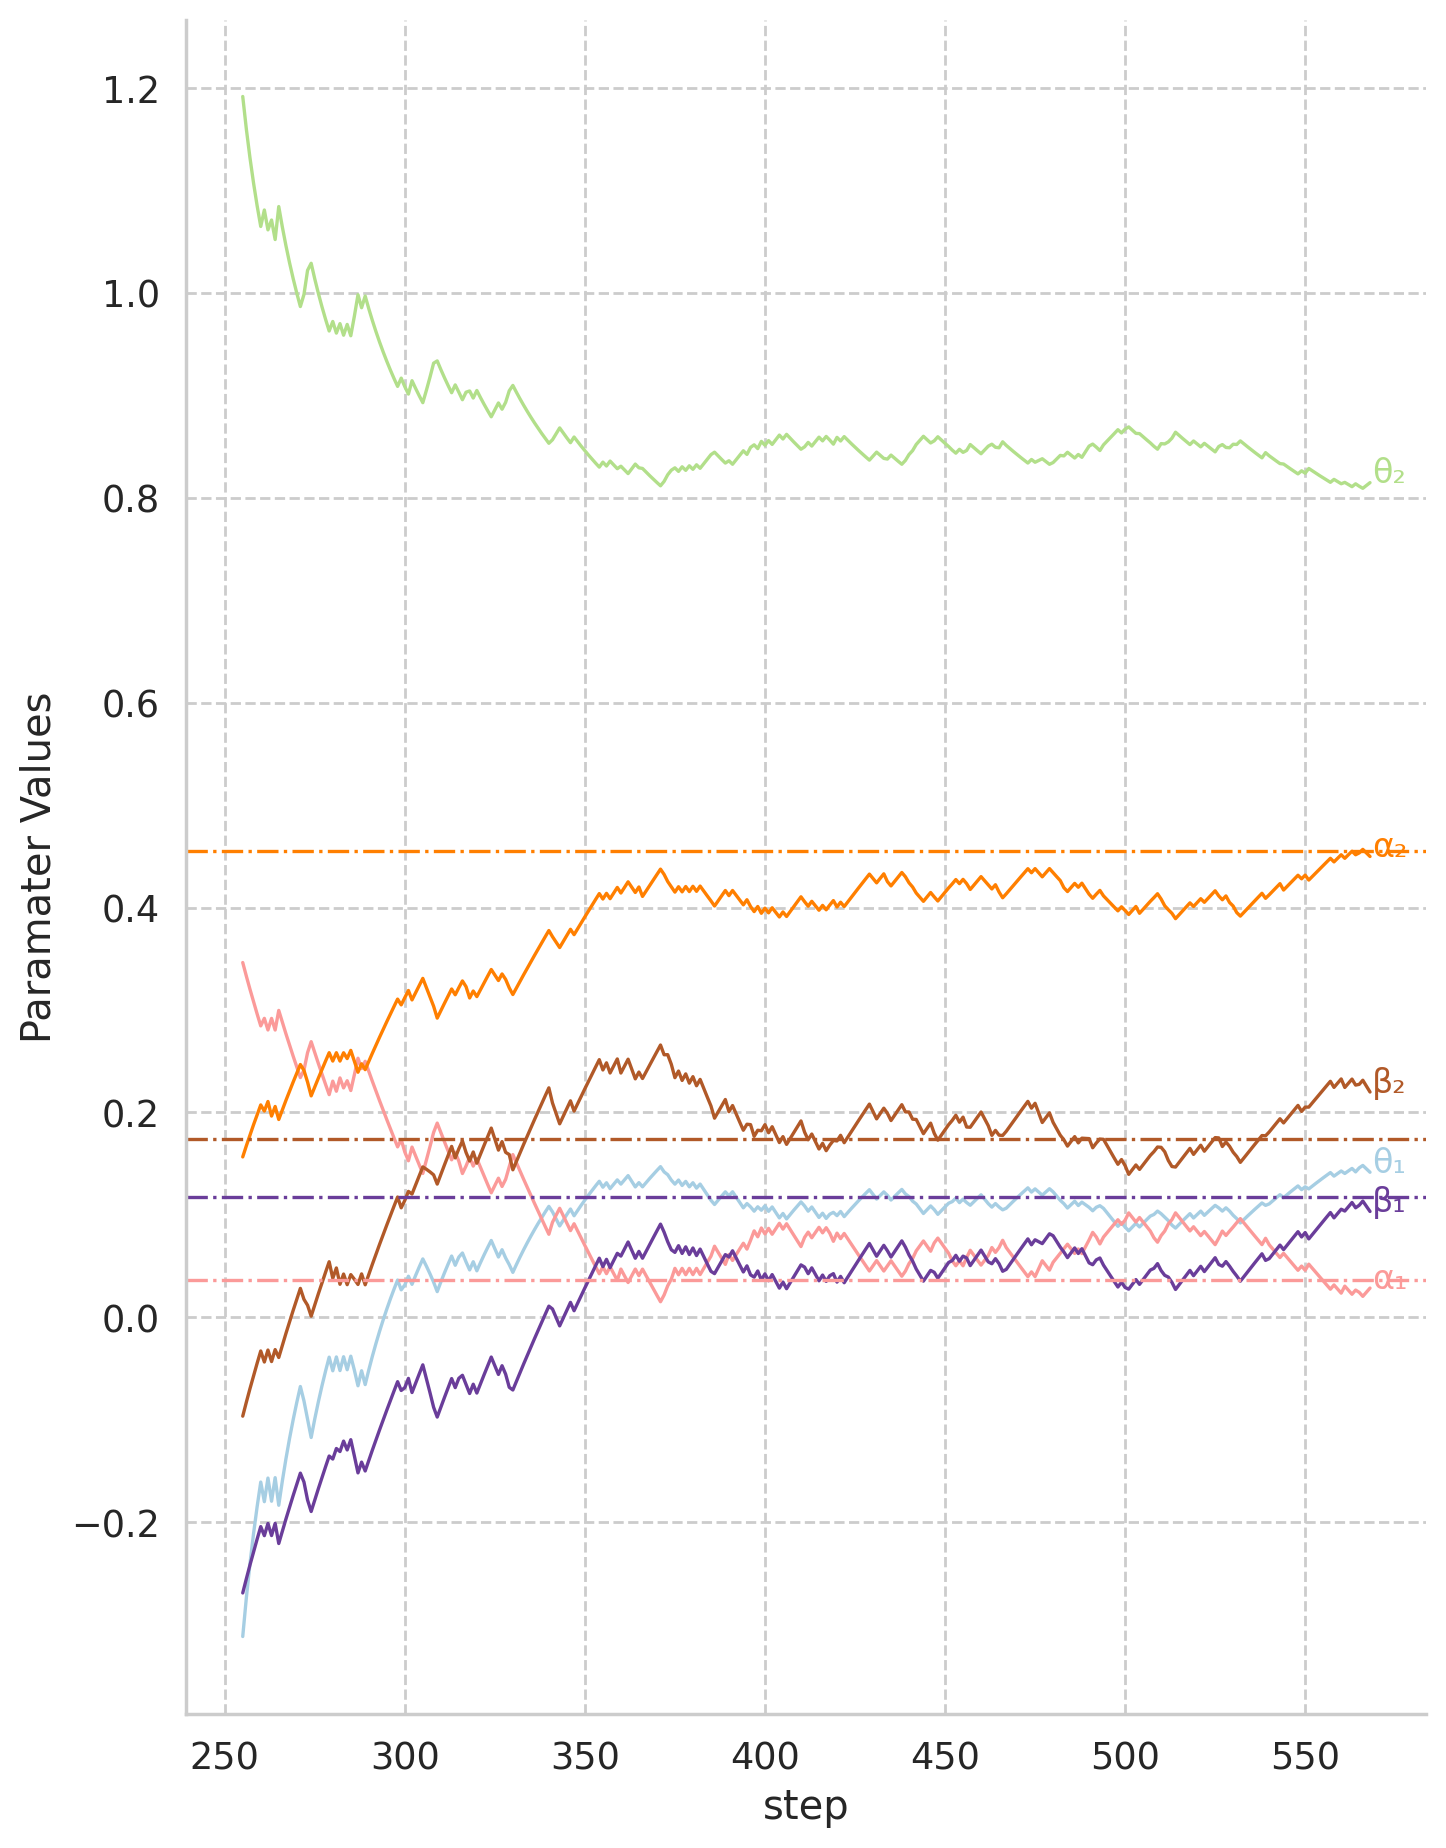

In [193]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

# I like my plots on a white background
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
sns.set_style("whitegrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)

k = 255
theta1_timeseries = [t[0] if t[0] != np.nan else 0 for t in ts][k:]
theta2_timeseries = [t[1] if t[1] != np.nan else 0 for t in ts][k:]

alpha1_timeseries = [t[2] if t[2] != np.nan else 0 for t in ts][k:]
alpha2_timeseries = [t[3] if t[3] != np.nan else 0 for t in ts][k:]

beta1_timeseries = [t[4] if t[4] != np.nan else 0 for t in ts][k:]
beta2_timeseries = [t[5] if t[5] != np.nan else 0 for t in ts][k:]

df = pd.DataFrame(
    {
        "step": [i for i in range(len(ts))][k:],
        "theta1": theta1_timeseries,
        "theta2": theta2_timeseries,
        "alpha1": alpha1_timeseries,
        "alpha2": alpha2_timeseries,
        "beta1": beta1_timeseries,
        "beta2": beta2_timeseries
    }
)

def legend_positions(df, y):
    """ Calculate position of labels to the right in plot... """
    positions = {}
    for column in y:    
        positions[column] = df[column].values[-1]  #- 1.5    

    def push():
        """
        ...by puting them to the last y value and
        pushing until no overlap
        """
        collisions = 0
        for column1, value1 in positions.items():
            for column2, value2 in positions.items():
                if column1 != column2:
                    dist = abs(value1-value2)
                    if dist < 0.02:
                        collisions += 1
                        if value1 < value2:
                            positions[column1] -= .01
                            positions[column2] += .01
                        else:
                            positions[column1] += .01
                            positions[column2] -= .01
                        return True
    while True:
        pushed = push()
        if not pushed:
            break

    return positions

x = 'step'
y = ['theta1', 'theta2', 'alpha1',
     'alpha2', 'beta1', 'beta2']
leg = [
    #"$\theta_1$", "$\theta_1$", "$\alpha_1$", "$\alpha_2$", "$\beta_1$", "$\beta_2$"
    "θ₁",
    "θ₂",
    "α₁",
    "α₂",
    "β₁",
    "β₂",
]
positions = legend_positions(df, y)

f, ax = plt.subplots(figsize=(8,11))        
cmap = plt.cm.get_cmap('Paired', len(y))

for i, (column, position) in enumerate(positions.items()):

    # Get a color
    color = cmap(float(i)/len(positions))
    # Plot each line separatly so we can be explicit about color
    ax = df.plot(x=x, y=column, legend=False, ax=ax, color=color)

    
    print(y[i], color)
    # Add the text to the right
    plt.text(
        df[x][df[column].last_valid_index()] + 0.5,
        position, leg[i], fontsize=12,
        color=color # Same color as line
    )
plt.axhline(y = 0.2*fpr1, color = (0.984313725490196, 0.6039215686274509, 0.6, 1.0), linestyle = '-.')
plt.axhline(y = 2*fnr1, color = (0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0), linestyle = '-.')
plt.axhline(y = 2*fpr2, color = (1.0, 0.4980392156862745, 0.0, 1.0), linestyle = '-.')
plt.axhline(y = 2*fnr2, color = (0.6941176470588235, 0.34901960784313724, 0.1568627450980392, 1.0), linestyle = '-.')

# Thetas

ax.set_ylabel('Paramater Values')
# Add percent signs
#ax.set_yticklabels(['{:3.0f}%'.format(x) for x in ax.get_yticks()])
sns.despine()

0.11627906976744186 0.056338028169014086

0.19148936170212766 0.1044776119402985

In [10]:
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing

model = compose.Pipeline(
     preprocessing.StandardScaler(),
     linear_model.LogisticRegression()
)

metric = metrics.Accuracy()
cm1 = metrics.ConfusionMatrix()\\
cm2 = metrics.ConfusionMatrix()
for x, y in dataset:
    y_pred = model.predict_one(x)      # make a prediction
    metric = metric.update(y, y_pred)  # update the metric
    model = model.learn_one(x, y)      # make the model learn

metric

Accuracy: 89.20%

In [194]:
gmm

GaussianMixture(n_components=2, random_state=0)



test var 1 :  2.427641781853164
test var 2 :  4.081790426805309


Text(0.5, 1.0, 'GMM Associated data')

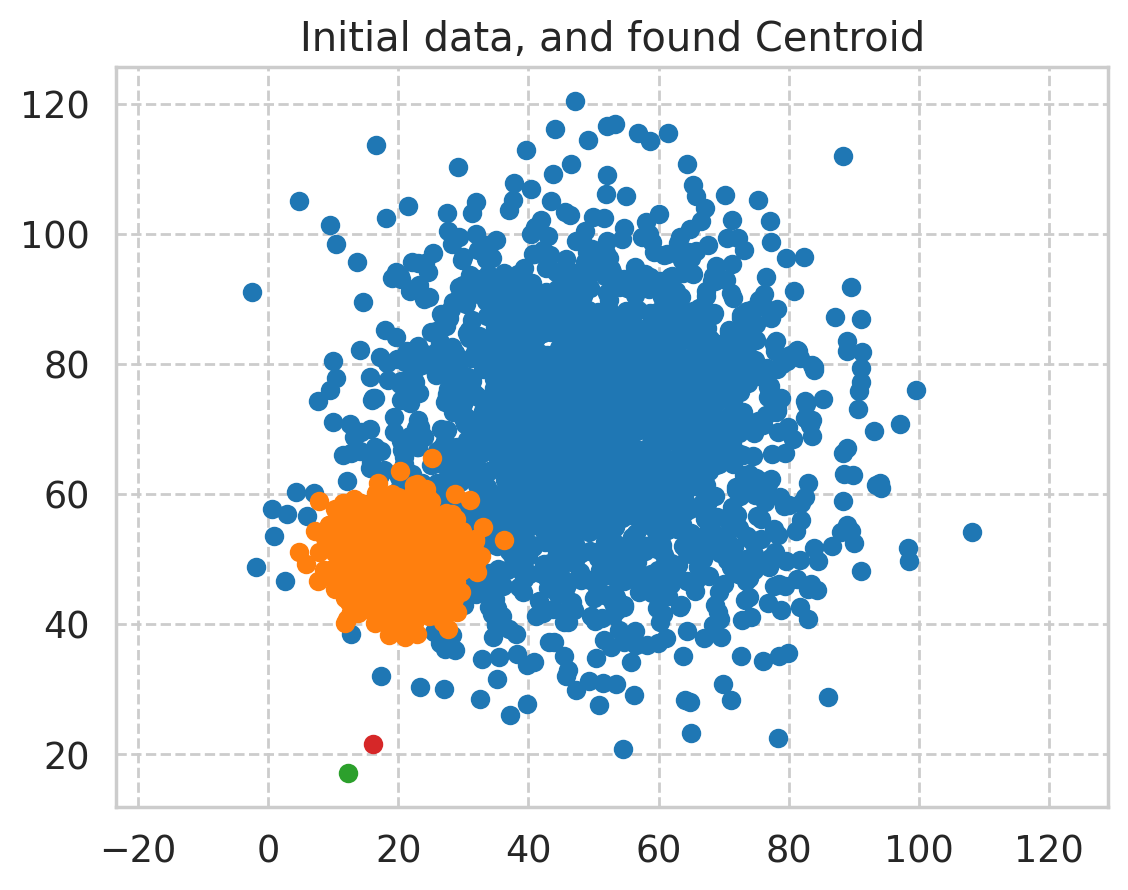

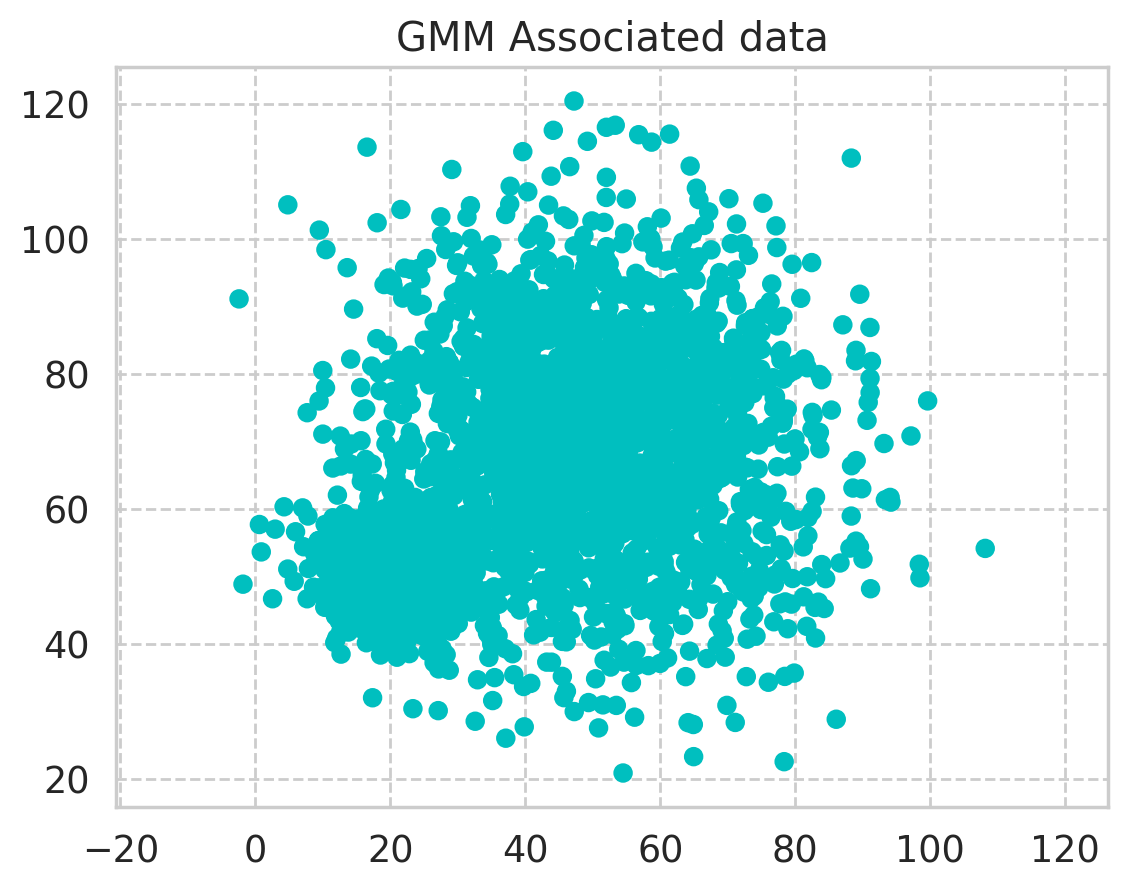

In [201]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import cluster, mixture

colorsList = ['c','r','g']
CustomCmap = matplotlib.colors.ListedColormap(colorsList)


sigma1=16
sigma2=4
npoints = 2000

s = (100,100)
x1 = np.random.normal( 50, sigma1, npoints )
y1 = np.random.normal( 70, sigma1, npoints )

x2 = np.random.normal( 20, sigma2, npoints )
y2 = np.random.normal( 50, sigma2, npoints )

x = np.hstack((x1,x2))
y = np.hstack((y1,y2))


# C = mixture.GaussianMixture(n_components= 2 , covariance_type='full'  )
# subdata = np.transpose( np.vstack((x,y)) )
# C.fit( subdata )

m = gmm.means_
w = gmm.weights_
cov = gmm.covariances_


print('\n')
print( 'test var 1 : ' , np.sqrt(  np.trace( cov[0]) /2 ) )
print( 'test var 2 : ' , np.sqrt(  np.trace( cov[1]) /2 ) )

plt.scatter(x1,y1)
plt.scatter(x2,y2)

plt.scatter( m[0,0], m[0,1])
plt.scatter( m[1,0], m[1,1])
plt.title('Initial data, and found Centroid')
plt.axis('equal')



gmm_sub_sigmas = [ np.sqrt(  np.trace(cov[i])/2) for i in range(0,2) ]
xdiff= (np.transpose(np.repeat([x],2 ,axis=0)) - m[:,0]) / gmm_sub_sigmas
ydiff= (np.transpose(np.repeat([y],2 ,axis=0)) - m[:,1]) / gmm_sub_sigmas
#            distances = np.hypot(xdiff,ydiff)  #not the effective distance for gaussian distributions...
distances = 0.5*np.hypot(xdiff,ydiff) + np.log(gmm_sub_sigmas)  # I believe this is a good estimate of closeness to a gaussian distribution
res2 = np.argmin( distances , axis=1) 

plt.figure()
plt.scatter(x,y, c=res2, cmap=CustomCmap )
plt.axis('equal')
plt.title('GMM Associated data')

In [202]:
gmm.means_

array([[12.29540428, 17.12306278,  0.03886907,  0.17320337],
       [16.1255877 , 21.6530467 ,  0.14326523,  0.1898433 ]])

In [2]:
import sys
!{sys.executable} -m pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.9 MB/s eta 0:00:00 MB/s eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 23.5 MB/s eta 0:00:00m eta 0:00:010:0101
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 21.9 MB/s eta 0:00:00


In [16]:
!pip install --upgrade numpy

  Using cached numpy-1.24.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tigramite 5.1.0.5 requires numpy==1.21.5, but you have numpy 1.24.1 which is incompatible.
thinc 8.0.8 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.10.4 which is incompatible.
spacy 3.1.1 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.10.4 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.1 which is incompatible.
cupy-cuda102 9.2.0 requires numpy<1.23,>=1.17, but you have numpy 1.24.1 which is incompatible.
